# Plotting Drake Passage Transport in ACCESS-CM3

This notebook uses the initial spinup simulation of ACCESS-CM3.

In [2]:
#The following cell must be in all notebooks!

In [3]:
#parameters

### USER EDIT start
esm_file='/g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json
Plot folder path:  /g/data/tm70/ek4684/access-om3-paper-figs/


In [4]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


In [5]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-CM3 data from ESM datastore

In [6]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [7]:
umo = datastore.search(variable="umo",).to_dataset_dict( xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks="auto",
        decode_timedelta=True
    )
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [8]:
key_3dz = [k for k in umo.keys() if ".z_l:" in k][0]
umo_3dz = umo[key_3dz]
del umo  # drop the whole dict
umo = {"3d_z": umo_3dz}  

In [9]:
ds = umo["3d_z"]            

zdim = "z_l" if "z_l" in ds["umo"].dims else "zl"

# Vertically integrate (sum over layers)
umo_2d = ds["umo"].sum(dim=zdim, skipna=True)   # -> (time, yh, xq)

umo_2d.attrs.update(long_name="Ocean Mass X Transport Vertical Sum")

## Load ACCESS-CM2 data from ACCESS-NRI Catalog

In [11]:
catalog = intake.cat.access_nri

In [12]:
var = catalog.search(variable='tx_trans_int_z',frequency="1mon")

In [13]:
var = catalog['cj877'].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"yh": -1, "xh": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


(-80.0, -40.0)

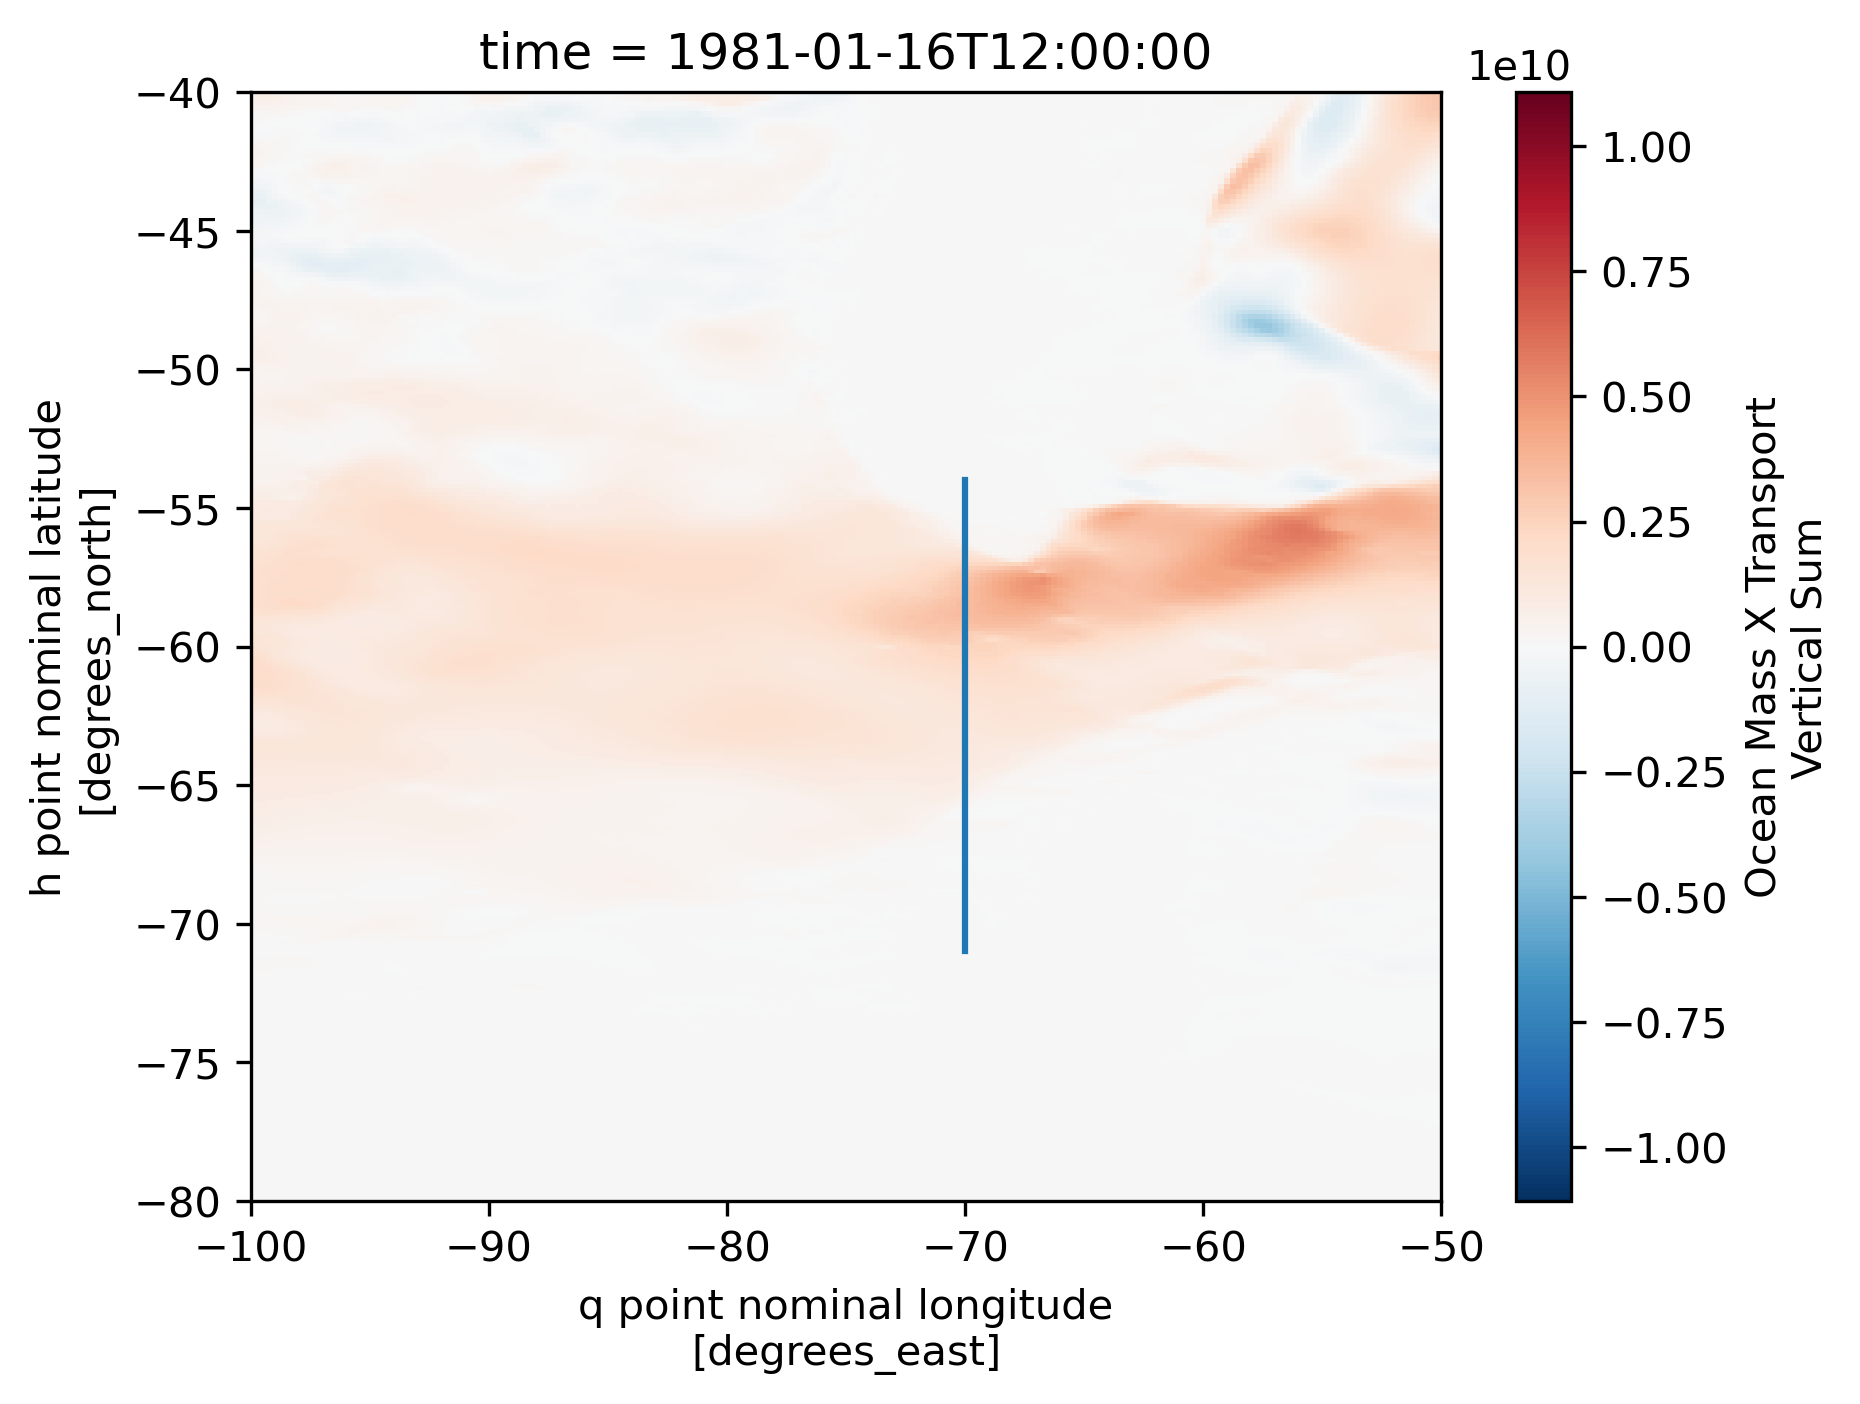

In [14]:
umo_2d.isel(time=0).plot()
plt.plot([-70,-70],[-71,-54])
plt.xlim([-100,-50])
plt.ylim([-80,-40])

## Timeseries of DP Transport at -70°

In [15]:
DP_Trans_CM3 = umo_2d.sel(xq=-70,method='nearest').sel(yh=slice(-71,-54)).sum("yh").load() / 1025 / 1e6

In [16]:
DP_Trans_CM2 = (
    tx_trans_int_z["tx_trans_int_z"]
    .sel(xu_ocean=-70, method="nearest")
    .sel(yt_ocean=slice(-71, -54)).sum("yt_ocean")
    .sel(time=slice(cftime.DatetimeProlepticGregorian(1,1,1), cftime.DatetimeProlepticGregorian(50,12,31))) 
    .chunk({"time": 60})                      
    .compute()
) / 1036 / 1e6

In [19]:
DP_Trans_CM2 = DP_Trans_CM2.convert_calendar(
    "proleptic_gregorian",   # match CM3’s calendar
    use_cftime=True
)

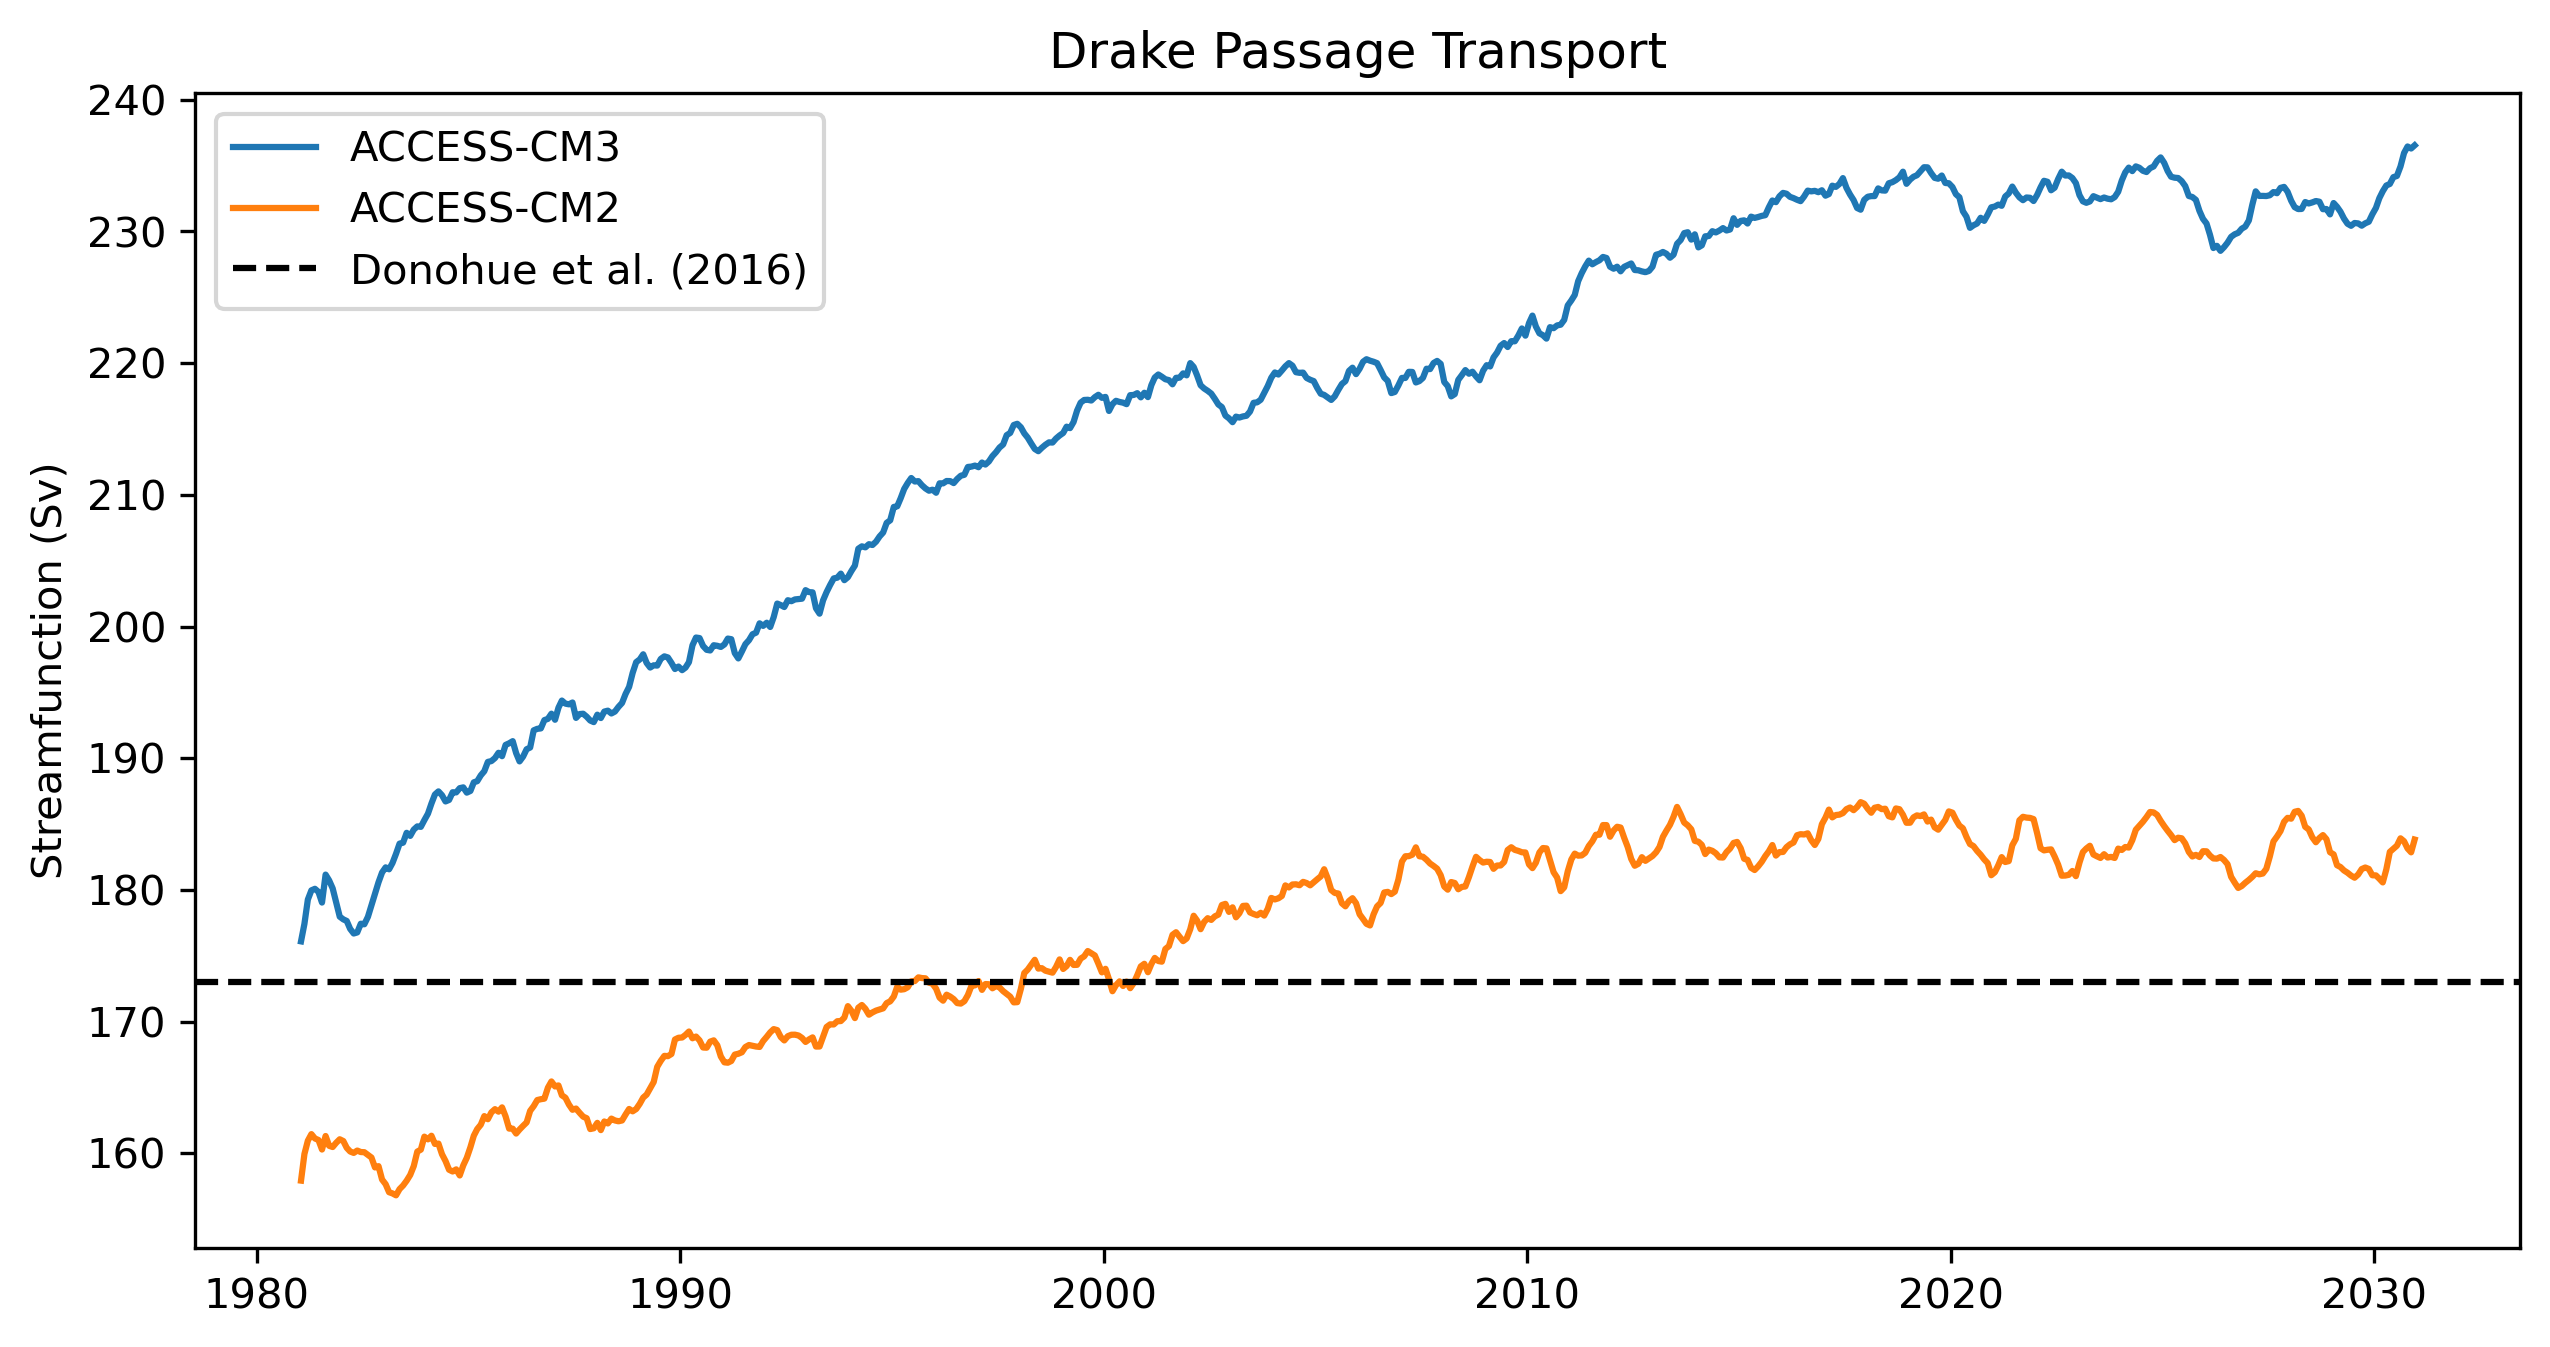

In [23]:
n = min(DP_Trans_CM2.sizes["time"], DP_Trans_CM3.sizes["time"])

# borrow CM3's time axis (cftime) for plotting
t = DP_Trans_CM3.isel(time=slice(0, n)).time.values

y_cm2 = (
    DP_Trans_CM2.isel(time=slice(0, n))
    .rolling(time=12, center=True, min_periods=6).mean()
    .compute().values
)
y_cm3 = (
    DP_Trans_CM3.isel(time=slice(0, n))
    .rolling(time=12, center=True, min_periods=6).mean()
    .compute().values
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t, y_cm3, label="ACCESS-CM3")
ax.plot(t, y_cm2, label="ACCESS-CM2")

ax.axhline(173, linestyle="--", color="k", label="Donohue et al. (2016)")

ax.set_ylabel("Streamfunction (Sv)")
ax.set_title("Drake Passage Transport")
ax.legend()
plt.show()


In [ ]:
client.close()